In [1]:
#Importing libraries
from typing import List, Tuple
import numpy as np
import pandas as pd
from typing import List, Optional
from tqdm import tqdm
from sklearn.utils.validation import check_is_fitted
import xgboost as xgb
import catboost as catb
from catboost.utils import get_roc_curve
from catboost import Pool
import lightgbm as lgb

import os
import json
import shap
import dill
import matplotlib.pyplot as plt
from collections import Counter
from PIL import  Image
import missingno as msno
%matplotlib inline

import seaborn as sns #visualization
import featuretools as ft
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

from featexp import get_univariate_plots

from scipy.stats import gmean, rankdata
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split, TimeSeriesSplit, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency, ks_2samp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder as le
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
plt.style.use('seaborn-whitegrid')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [3]:
def plot_roc_curve(**kwargs):
    res_lst = []
    
    for k, v in kwargs.items():  
        fpr, tpr, _ = roc_curve(v[0], v[1])
        res_lst.append((fpr, tpr, k))
    
    plt.figure(figsize=(20,10))
    for res in res_lst:
        plt.plot(res[0], res[1], label=res[2])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend()
    plt.show()
    
    return res_lst

In [70]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          params = None,
                          groups: pd.Series = pd.Series(), 
                          categorical = None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
    groups:
        Если в cv_strategy передаем GroupKFold, то нужно передать groups,
        чтобы разделять по этим данным датасет на группы
    categorical:
        Список названий признаков - категорий

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])
    if len(groups) > 0:
        cv_generator = cv_strategy.split(X, y, groups)
    else:
        cv_generator = cv_strategy.split(X, y)

        
    if estimator.__name__ == 'lightgbm':
        train_func = lgb_train
        X[categorical] = X[categorical].astype('category')
        if not categorical:
            categorical = 'auto'
    elif estimator.__name__ == 'xgboost':
        train_func = xgb_train
        if categorical:
            for feature in categorical:
                encoder = le()
                X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
    elif estimator.__name__ == 'catboost':
        train_func = catb_train
        if categorical:
            X[categorical] = X[categorical].astype(str)
    elif estimator.__name__ == 'rfc':
        train_func = rfc_train
        if categorical:
            for feature in categorical:
                encoder = le()
                X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
                X = X.fillna(-99999)
        
        
    for fold_number, (train_idx, valid_idx) in enumerate(cv_generator):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        

        model_train, y_train_pred, y_valid_pred = train_func(estimator, x_train, y_train, 
                                                             x_valid, y_valid, params, categorical)
            
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(model_train)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [75]:
def rfc_train(estimator, x_train, y_train, x_valid, y_valid, _, __):

    estimator.fit(x_train, y_train)
    y_train_pred = estimator.predict_proba(x_train)
    y_valid_pred = estimator.predict_proba(x_valid)
    
    return estimator, y_train_pred[:,1], y_valid_pred[:,1]

In [6]:
def xgb_train(estimator, x_train, y_train, x_valid, y_valid, params, _):
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    dvalid = xgb.DMatrix(data=x_valid, label=y_valid)

    model = estimator.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        verbose_eval=True,
        maximize=True,
    )
    
    y_train_pred = model.predict(dtrain)
    y_valid_pred = model.predict(dvalid)
    
    return model, y_train_pred, y_valid_pred

In [7]:
def catb_train(estimator, x_train, y_train, x_valid, y_valid, params, categorical):
    
    train_pool = catb.Pool(x_train, y_train, cat_features=categorical)
    valid_pool = catb.Pool(x_valid, y_valid, cat_features=categorical)
    
    model = estimator.CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool)
    
    y_train_pred = model.predict(x_train, prediction_type='Probability')
    y_valid_pred = model.predict(x_valid, prediction_type='Probability')
    
    return model, y_train_pred[:,1], y_valid_pred[:,1]

In [8]:
def lgb_train(estimator, x_train, y_train, x_valid, y_valid, params, categorical):
    
    dtrain = lgb.Dataset(data=x_train, label=y_train)
    dvalid = lgb.Dataset(data=x_valid, label=y_valid)
    
    model = estimator.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dvalid],
        categorical_feature=categorical,
        early_stopping_rounds=50,
        verbose_eval=10
    )
    
    y_train_pred = model.predict(x_train)
    y_valid_pred = model.predict(x_valid)
    
    return model, y_train_pred, y_valid_pred

In [10]:
# applications_history = pd.read_csv("data/applications_history.csv")
# bki = pd.read_csv("data/bki.csv")
client_profile = pd.read_csv("data/client_profile.csv")
# payments = pd.read_csv("data/payments.csv")
# sample_submit = pd.read_csv("data/sample_submit.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# print("applications_history.shape = {} rows, {} cols".format(*applications_history.shape))
# print("bki.shape = {} rows, {} cols".format(*bki.shape))
print("client_profile.shape = {} rows, {} cols".format(*client_profile.shape))
# print("payments.shape = {} rows, {} cols".format(*payments.shape))
# print("sample_submit.shape = {} rows, {} cols".format(*sample_submit.shape))
print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

client_profile.shape = 250000 rows, 24 cols
train.shape = 110093 rows, 3 cols
test.shape = 165141 rows, 2 cols


In [11]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    X.columns = [col.lower() for col in X.columns]
    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / X["age"]
    X["ratio_credit_to_age"] = X["amount_credit"] / X["age"]
    X["ratio_salary_to_age"] = X["total_salary"] / X["age"]
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = X["age"] / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]

    return X

In [12]:
tt_data = pd.concat([train.assign(is_test=0), 
                     test.assign(is_test=1)], axis=0)
tt_data.shape

(275234, 4)

In [13]:
tt_data.columns = [col.lower() for col in tt_data.columns]
tt_data.head(2)

,application_number,target,name_contract_type,is_test
0,123687442,0.0,Cash,0
1,123597908,1.0,Cash,0


In [14]:
client_profile2 = create_client_profile_features(client_profile)
client_profile2.head(n=2)

,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,days_on_last_job,own_car_age,flag_phone,flag_email,family_size,external_scoring_rating_1,external_scoring_rating_2,external_scoring_rating_3,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,bki_requests_count,bki_kurtosis,external_scoring_prod,external_scoring_weighted,external_scoring_rating_min,external_scoring_rating_max,external_scoring_rating_mean,external_scoring_rating_nanmedian,external_scoring_rating_var,ratio_credit_to_annuity,ratio_annuity_to_salary,ratio_credit_to_salary,ratio_annuity_to_age,ratio_credit_to_age,ratio_salary_to_age,ratio_salary_to_experience,ratio_credit_to_experience,ratio_annuity_to_experience,ratio_age_to_experience,ratio_salary_to_region_population,ratio_car_to_experience,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,1549.0,NaN,1,0,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.428571,0.052832,2.930959,0.236315,0.678568,0.414784,0.329471,0.036237,20.00000,0.085714,1.714286,1.577103,31.542056,18.399533,101.678502,174.306004,8.7153,5.526146,1270.71,NaN,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,NaN,NaN,0,0,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.875000,NaN,NaN,0.442295,0.802745,0.622520,0.622520,0.032481,18.86105,0.105433,1.988583,1.227714,23.155971,11.644456,NaN,NaN,NaN,NaN,5466.42,NaN,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462


In [15]:
data = tt_data.merge(
    client_profile2, how="left", on="application_number"
)

In [16]:
#Разбиваем признаки по типам: числовые, нечисловые, цель
num_features_res = data.select_dtypes("number").columns.to_list()
dum_features_res = data.select_dtypes("object").columns.to_list()
len(num_features_res), len(dum_features_res)

(51, 4)

In [17]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=1)

__Задание 1__ Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [18]:
train = data.loc[data.is_test == 0].drop(['is_test', 'target', 'application_number'], axis=1)
test = data.loc[data.is_test == 1].drop(['is_test', 'target', 'application_number'], axis=1)
target = data.loc[data.is_test == 0, 'target']

- Обучим LightGBM:

In [19]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "n_jobs": 6,
    "seed": 27
}

In [20]:
%%time
estimators_lgb, oof_score_lgb, fold_train_scores_lgb, fold_valid_scores_lgb, oof_predictions_lgb = make_cross_validation(
    train, target, lgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, categorical=dum_features_res
)

[LightGBM] [Info] Number of positive: 7118, number of negative: 80956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8972
[LightGBM] [Info] Number of data points in the train set: 88074, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080818 -> initscore=-2.431279
[LightGBM] [Info] Start training from score -2.431279
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.708678	valid_1's auc: 0.698234
[20]	training's auc: 0.714119	valid_1's auc: 0.703042
[30]	training's auc: 0.717545	valid_1's auc: 0.70572
[40]	training's auc: 0.721119	valid_1's auc: 0.707003
[50]	training's auc: 0.724156	valid_1's auc: 0.708052
[60]	training's auc: 0.726853	valid_1's auc: 0.708531
[70]	training's auc: 0.729025	valid_1's auc: 0.708603
[80]	training's auc: 0.73167	valid_1's auc: 0.709518
[90]	training

[10]	training's auc: 0.709085	valid_1's auc: 0.705081
[20]	training's auc: 0.712324	valid_1's auc: 0.708534
[30]	training's auc: 0.716483	valid_1's auc: 0.712094
[40]	training's auc: 0.719748	valid_1's auc: 0.714131
[50]	training's auc: 0.722223	valid_1's auc: 0.714996
[60]	training's auc: 0.725089	valid_1's auc: 0.715645
[70]	training's auc: 0.727297	valid_1's auc: 0.716878
[80]	training's auc: 0.728948	valid_1's auc: 0.717516
[90]	training's auc: 0.730874	valid_1's auc: 0.718458
[100]	training's auc: 0.732532	valid_1's auc: 0.719826
[110]	training's auc: 0.734076	valid_1's auc: 0.720144
[120]	training's auc: 0.736629	valid_1's auc: 0.721307
[130]	training's auc: 0.738318	valid_1's auc: 0.721687
[140]	training's auc: 0.740175	valid_1's auc: 0.722352
[150]	training's auc: 0.741759	valid_1's auc: 0.723065
[160]	training's auc: 0.743081	valid_1's auc: 0.723507
[170]	training's auc: 0.744666	valid_1's auc: 0.723772
[180]	training's auc: 0.746328	valid_1's auc: 0.724084
[190]	training's au

[LightGBM] [Info] Number of positive: 7118, number of negative: 80957
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8976
[LightGBM] [Info] Number of data points in the train set: 88075, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080817 -> initscore=-2.431291
[LightGBM] [Info] Start training from score -2.431291
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.704418	valid_1's auc: 0.703168
[20]	training's auc: 0.711644	valid_1's auc: 0.709612
[30]	training's auc: 0.715043	valid_1's auc: 0.710994
[40]	training's auc: 0.719193	valid_1's auc: 0.714117
[50]	training's auc: 0.721851	valid_1's auc: 0.716014
[60]	training's auc: 0.723709	valid_1's auc: 0.716794
[70]	training's auc: 0.725789	valid_1's auc: 0.718507
[80]	training's auc: 0.727697	valid_1's auc: 0.719987
[90]	traini

- Обучим XGBoost:

In [21]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [22]:
%%time
estimators_xgb, oof_score_xgb, fold_train_scores_xgb, fold_valid_scores_xgb, oof_predictions_xgb = make_cross_validation(
    train, target, xgb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, categorical=dum_features_res
)

[0]	train-auc:0.60106	valid-auc:0.59683
[1]	train-auc:0.62914	valid-auc:0.62025
[2]	train-auc:0.62915	valid-auc:0.62027
[3]	train-auc:0.67793	valid-auc:0.67666
[4]	train-auc:0.67924	valid-auc:0.67857
[5]	train-auc:0.68097	valid-auc:0.68056
[6]	train-auc:0.68104	valid-auc:0.68065
[7]	train-auc:0.68370	valid-auc:0.68344
[8]	train-auc:0.68407	valid-auc:0.68370
[9]	train-auc:0.68425	valid-auc:0.68371
[10]	train-auc:0.68716	valid-auc:0.68723
[11]	train-auc:0.68762	valid-auc:0.68759
[12]	train-auc:0.68816	valid-auc:0.68797
[13]	train-auc:0.68837	valid-auc:0.68817
[14]	train-auc:0.69114	valid-auc:0.68842
[15]	train-auc:0.69193	valid-auc:0.68923
[16]	train-auc:0.69226	valid-auc:0.68930
[17]	train-auc:0.69252	valid-auc:0.68956
[18]	train-auc:0.69286	valid-auc:0.68966
[19]	train-auc:0.69465	valid-auc:0.69179
[20]	train-auc:0.69578	valid-auc:0.69326
[21]	train-auc:0.69818	valid-auc:0.69492
[22]	train-auc:0.70020	valid-auc:0.69680
[23]	train-auc:0.70152	valid-auc:0.69781
[24]	train-auc:0.70363	val

[39]	train-auc:0.71842	valid-auc:0.70353
[40]	train-auc:0.71944	valid-auc:0.70405
[41]	train-auc:0.72044	valid-auc:0.70500
[42]	train-auc:0.72064	valid-auc:0.70552
[43]	train-auc:0.72132	valid-auc:0.70614
[44]	train-auc:0.72181	valid-auc:0.70631
[45]	train-auc:0.72238	valid-auc:0.70653
[46]	train-auc:0.72303	valid-auc:0.70710
[47]	train-auc:0.72392	valid-auc:0.70778
[48]	train-auc:0.72449	valid-auc:0.70873
[49]	train-auc:0.72476	valid-auc:0.70866
[50]	train-auc:0.72558	valid-auc:0.70907
[51]	train-auc:0.72625	valid-auc:0.70937
[52]	train-auc:0.72675	valid-auc:0.70950
[53]	train-auc:0.72707	valid-auc:0.70982
[54]	train-auc:0.72736	valid-auc:0.70999
[55]	train-auc:0.72802	valid-auc:0.71081
[56]	train-auc:0.72852	valid-auc:0.71139
[57]	train-auc:0.72869	valid-auc:0.71164
[58]	train-auc:0.72905	valid-auc:0.71170
[59]	train-auc:0.72966	valid-auc:0.71110
[60]	train-auc:0.72981	valid-auc:0.71172
[61]	train-auc:0.73013	valid-auc:0.71193
[62]	train-auc:0.73038	valid-auc:0.71231
[63]	train-auc:0

[105]	train-auc:0.73386	valid-auc:0.72616
[106]	train-auc:0.73386	valid-auc:0.72616
[107]	train-auc:0.73386	valid-auc:0.72616
[108]	train-auc:0.73386	valid-auc:0.72616
[109]	train-auc:0.73386	valid-auc:0.72616
[110]	train-auc:0.73386	valid-auc:0.72616
[111]	train-auc:0.73386	valid-auc:0.72616
[112]	train-auc:0.73386	valid-auc:0.72616
[113]	train-auc:0.73386	valid-auc:0.72616
[114]	train-auc:0.73386	valid-auc:0.72616
[115]	train-auc:0.73386	valid-auc:0.72616
[116]	train-auc:0.73386	valid-auc:0.72616
[117]	train-auc:0.73386	valid-auc:0.72616
[118]	train-auc:0.73386	valid-auc:0.72616
[119]	train-auc:0.73386	valid-auc:0.72616
[120]	train-auc:0.73386	valid-auc:0.72616
[121]	train-auc:0.73386	valid-auc:0.72616
[122]	train-auc:0.73386	valid-auc:0.72616
[123]	train-auc:0.73386	valid-auc:0.72616
[124]	train-auc:0.73386	valid-auc:0.72616
[125]	train-auc:0.73386	valid-auc:0.72616
[126]	train-auc:0.73386	valid-auc:0.72616
[127]	train-auc:0.73386	valid-auc:0.72616
[128]	train-auc:0.73386	valid-auc:

[5]	train-auc:0.67836	valid-auc:0.68844
[6]	train-auc:0.67908	valid-auc:0.68966
[7]	train-auc:0.68134	valid-auc:0.69219
[8]	train-auc:0.68361	valid-auc:0.69374
[9]	train-auc:0.68458	valid-auc:0.69481
[10]	train-auc:0.68503	valid-auc:0.69525
[11]	train-auc:0.68563	valid-auc:0.69550
[12]	train-auc:0.68560	valid-auc:0.69581
[13]	train-auc:0.68581	valid-auc:0.69590
[14]	train-auc:0.68788	valid-auc:0.69822
[15]	train-auc:0.68791	valid-auc:0.69783
[16]	train-auc:0.68801	valid-auc:0.69786
[17]	train-auc:0.68969	valid-auc:0.69873
[18]	train-auc:0.69156	valid-auc:0.70122
[19]	train-auc:0.69247	valid-auc:0.70168
[20]	train-auc:0.69263	valid-auc:0.70164
[21]	train-auc:0.69670	valid-auc:0.70531
[22]	train-auc:0.69736	valid-auc:0.70557
[23]	train-auc:0.69909	valid-auc:0.70634
[24]	train-auc:0.70108	valid-auc:0.70788
[25]	train-auc:0.70213	valid-auc:0.70805
[26]	train-auc:0.70323	valid-auc:0.70816
[27]	train-auc:0.70374	valid-auc:0.70874
[28]	train-auc:0.70556	valid-auc:0.70971
[29]	train-auc:0.7063

- Посчитаем корреляцию на трейне:

In [23]:
scores = pd.DataFrame({
    "lgb": oof_predictions_lgb,
    "xgb": oof_predictions_xgb,
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

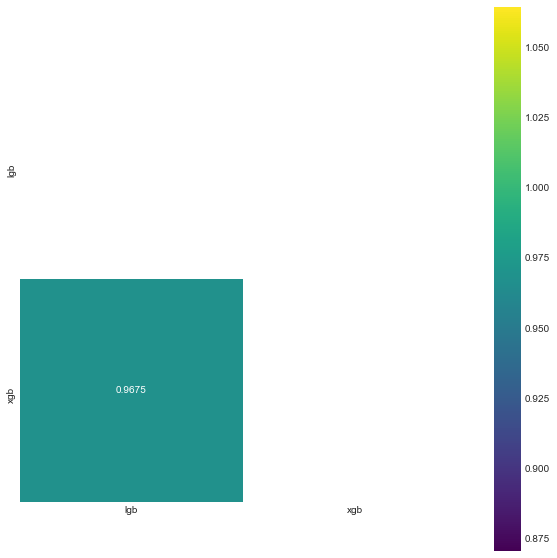

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

- Посчитаем корреляцию на тесте:

In [25]:
test_lgb = test.copy()
test_lgb[dum_features_res] = test_lgb[dum_features_res].astype('category')
y_pred_test = []
for est in estimators_lgb:
    y_pred_test.append(est.predict(test_lgb))

In [26]:
y_pred_test_lgb2 = np.average(np.array(y_pred_test), axis=0)
y_pred_test_lgb2.shape

(165141,)

In [27]:
test_xgb = test.copy()
for feature in dum_features_res:
    encoder = le()
    test_xgb[feature] = encoder.fit_transform(test_xgb[feature].astype("str").fillna("NA"))
                
dtest_xgb = xgb.DMatrix(data=test_xgb)
y_pred_test = []
for est in estimators_xgb:
    y_pred_test.append(est.predict(dtest_xgb))

In [28]:
y_pred_test_xgb2 = np.average(np.array(y_pred_test), axis=0)
y_pred_test_xgb2.shape

(165141,)

In [29]:
scores_test = pd.DataFrame({
    "lgb": y_pred_test_lgb2,
    "xgb": y_pred_test_xgb2,
})

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

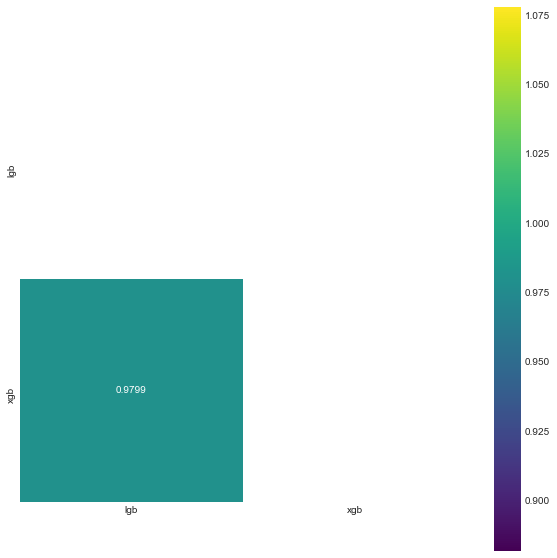

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

__Задание 2__ Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

- Арифмитическое среднее:

In [31]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7257


- Геометрическое среднее:

In [32]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7257


- Усредним ранки:

In [33]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7255


In [34]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7255


- Поскольку у меня сравнивается всего 2 модели, то арифмитическое и геометрическое среднее одинаково, и также с ранками.
- Метрика по среднему немного хуже, чем результат по LightGBM (OOF-score = 0.7259)

__Задание 3__ Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [35]:
params = {
    "n_estimators": 1000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 40,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [36]:
%%time
estimators_catb, oof_score_catb, fold_train_scores_catb, fold_valid_scores_catb, oof_predictions_catb = make_cross_validation(
    train, target, catb, metric=roc_auc_score, cv_strategy=cv_strategy, params=params, categorical=dum_features_res
)

0:	test: 0.5868949	best: 0.5868949 (0)	total: 209ms	remaining: 3m 28s
40:	test: 0.7012073	best: 0.7014921 (39)	total: 4.46s	remaining: 1m 44s
80:	test: 0.7078920	best: 0.7078920 (79)	total: 8.39s	remaining: 1m 35s
120:	test: 0.7129155	best: 0.7129155 (120)	total: 12.5s	remaining: 1m 31s
160:	test: 0.7166007	best: 0.7166007 (160)	total: 16.6s	remaining: 1m 26s
200:	test: 0.7188044	best: 0.7188596 (193)	total: 20.5s	remaining: 1m 21s
240:	test: 0.7205341	best: 0.7206402 (239)	total: 24.5s	remaining: 1m 17s
280:	test: 0.7209104	best: 0.7209380 (276)	total: 28.2s	remaining: 1m 12s
320:	test: 0.7217523	best: 0.7217523 (320)	total: 32.2s	remaining: 1m 8s
360:	test: 0.7223142	best: 0.7226586 (346)	total: 36.1s	remaining: 1m 3s
400:	test: 0.7226656	best: 0.7228630 (390)	total: 40.1s	remaining: 60s
440:	test: 0.7233432	best: 0.7233432 (440)	total: 43.5s	remaining: 55.2s
480:	test: 0.7234314	best: 0.7236314 (473)	total: 47.2s	remaining: 50.9s
520:	test: 0.7236923	best: 0.7239173 (505)	total: 50.

In [37]:
scores['catb'] = oof_predictions_catb

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

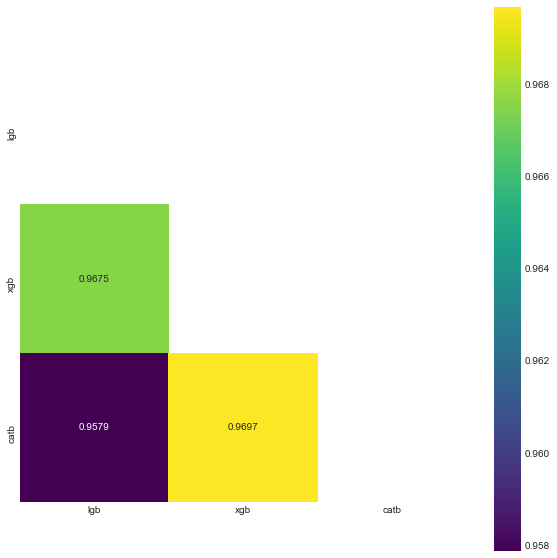

In [38]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

- Посчитаем корреляцию на тесте:

In [39]:
test_catb = test.copy()
test_catb[dum_features_res] = test_catb[dum_features_res].astype(str)
y_pred_test = []
for est in estimators_catb:
    y_pred_test.append(est.predict(test_catb, prediction_type='Probability')[:,1])

In [40]:
y_pred_test_catb2 = np.average(np.array(y_pred_test), axis=0)
y_pred_test_catb2.shape

(165141,)

In [41]:
scores_test['catb'] = y_pred_test_catb2

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

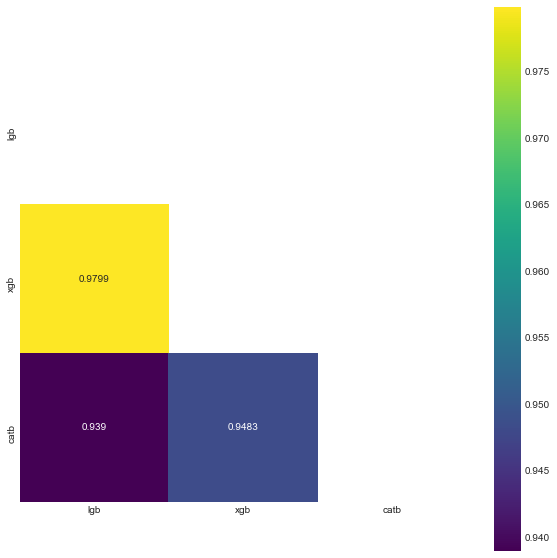

In [42]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

__Задание 4__ Выполнить задание 2 для трех моделей.

- Арифмитическое среднее:

In [43]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7265


- Геометрическое среднее:

In [44]:
scores_gmean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7265


- Усредним ранки:

In [45]:
# ROC-AUC / GINI
rank_scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, rank_scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7261


In [46]:
rank_scores_gmean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, rank_scores_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7262


- На трех моделях качество стало выше, чем на двух или отдельно на каждой  
- Геометрические среднее и ранки выше, чем арифметические

__Задание 5__ (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [47]:
y = target.values

In [56]:
lr = LogisticRegression(solver="liblinear", n_jobs=-1)

lr.fit(scores, y)

y_train_pred_lr = lr.predict_proba(scores)

score = roc_auc_score(y, y_train_pred_lr[:,1])
print(f"Score = {round(score, 4)}")

Score = 0.7269


- Результат конечно немного лучше стал, но не так, как хотелось бы )

__Задание 6__ (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [266]:
parameters = {
    'n_estimators': [200, 300, 500],
    'max_features': np.arange(10, 18),
    'max_depth': np.arange(10, 18),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(criterion='entropy'),
    param_grid=parameters,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

In [275]:
train2 = train.copy()
for feature in dum_features_res:
    encoder = le()
    train2[feature] = encoder.fit_transform(train2[feature].astype("str").fillna("NA"))
train2 = train2.fillna(-99999)

In [ ]:
%%time
clf.fit(train2, target)

In [ ]:
clf.best_params_

In [73]:
rfc = RandomForestClassifier(max_depth=14, 
                             max_features=14,
                             n_estimators=500, 
                             criterion='entropy',
                             verbose=1
                            )
rfc.__name__ = 'rfc'

In [76]:
%%time
estimators_rfc, oof_score_rfc, fold_train_scores_rfc, fold_valid_scores_rfc, oof_predictions_rfc = make_cross_validation(
    train, target, rfc, metric=roc_auc_score, cv_strategy=cv_strategy, categorical=dum_features_res
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.6s finished


Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.9392, valid-score = 0.7093


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.7s finished


Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.9396, valid-score = 0.7046


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.939, valid-score = 0.7143


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.9403, valid-score = 0.7086


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.94, valid-score = 0.7158
CV-results train: 0.9396 +/- 0.0
CV-results valid: 0.7105 +/- 0.004
OOF-score = 0.7101
Wall time: 53min 41s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.8s finished


In [77]:
scores['rfc'] = oof_predictions_rfc

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

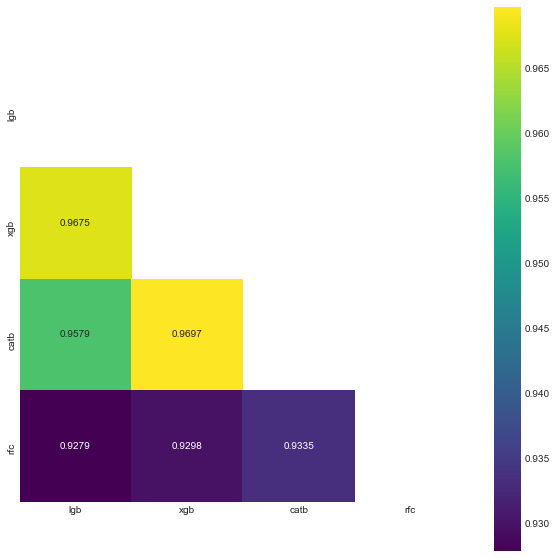

In [78]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

- Посчитаем корреляцию на тесте:

In [111]:
test_rfc = test.copy()
for feature in dum_features_res:
    encoder = le()
    test_rfc[feature] = encoder.fit_transform(test_rfc[feature].astype("str").fillna("NA"))
test_rfc = test_rfc.fillna(-9999)

In [112]:
np.isinf(test_rfc).sum()

name_contract_type                   0
gender                               0
childrens                            0
total_salary                         0
amount_credit                        0
amount_annuity                       0
education_level                      0
family_status                        0
region_population                    0
age                                  0
days_on_last_job                     0
own_car_age                          0
flag_phone                           0
flag_email                           0
family_size                          0
external_scoring_rating_1            0
external_scoring_rating_2            0
external_scoring_rating_3            0
amt_req_credit_bureau_hour           0
amt_req_credit_bureau_day            0
amt_req_credit_bureau_week           0
amt_req_credit_bureau_mon            0
amt_req_credit_bureau_qrt            0
amt_req_credit_bureau_year           0
bki_requests_count                   0
bki_kurtosis             

In [113]:
test_rfc.loc[test_rfc['ratio_salary_to_experience']==np.inf, 'ratio_salary_to_experience'] = 99999999
test_rfc.loc[test_rfc['ratio_credit_to_experience']==np.inf, 'ratio_credit_to_experience'] = 99999999
test_rfc.loc[test_rfc['ratio_annuity_to_experience']==np.inf, 'ratio_annuity_to_experience'] = 99999999
test_rfc.loc[test_rfc['ratio_age_to_experience']==np.inf, 'ratio_age_to_experience'] = 99999999

In [115]:
y_pred_test = []
for est in estimators_rfc:
    y_pred_test.append(est.predict_proba(test_rfc)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   27.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   28.1s finished


In [116]:
y_pred_test_rfc2 = np.average(np.array(y_pred_test), axis=0)
y_pred_test_rfc2.shape

(165141,)

In [117]:
scores_test['rfc'] = y_pred_test_rfc2

corr = scores_test.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

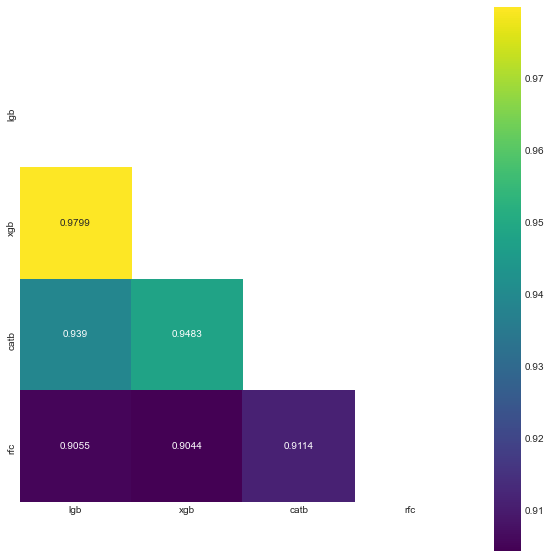

In [118]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

- Арифмитическое среднее:

In [79]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7242


- Геометрическое среднее:

In [80]:
scores_gmean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7244


- Усредним ранки:

In [81]:
# ROC-AUC / GINI
rank_scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, rank_scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7241


In [82]:
rank_scores_gmean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, rank_scores_gmean)
print(f"Score = {round(score, 4)}")

Score = 0.7242


- RandomForest ухудшил среднее качество

In [83]:
lr = LogisticRegression(solver="liblinear", n_jobs=-1)

lr.fit(scores, y)

y_train_pred_lr = lr.predict_proba(scores)

score = roc_auc_score(y, y_train_pred_lr[:,1])
print(f"Score = {round(score, 4)}")

Score = 0.727


In [119]:
y_test_pred_lr = lr.predict_proba(scores_test)

In [129]:
submition_df = pd.DataFrame({
    'APPLICATION_NUMBER': data.loc[data.is_test == 1, 'application_number'].values,
    'TARGET': y_test_pred_lr[:,1]
})

In [131]:
submition_df.to_csv('submition.csv', index=False)

- Unused:

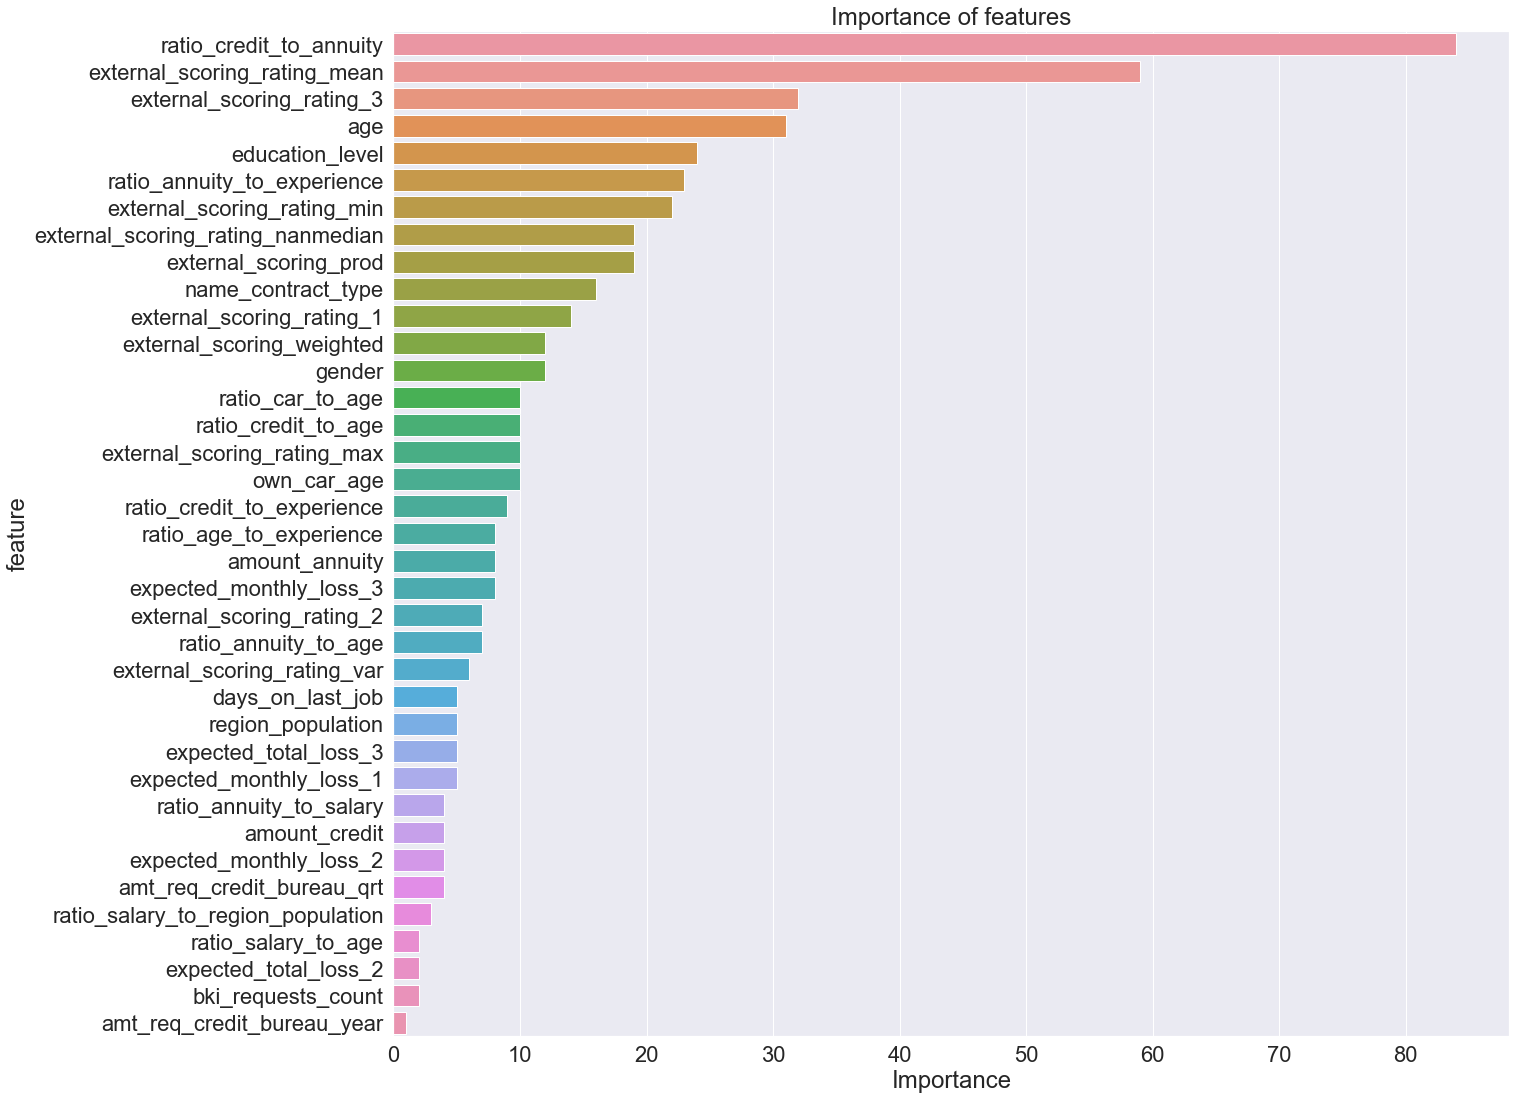

In [222]:
#weight
sns.set(font_scale = 2)
feature_important = estimators_xgb[0].get_score(importance_type='weight')
important_features_top1 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

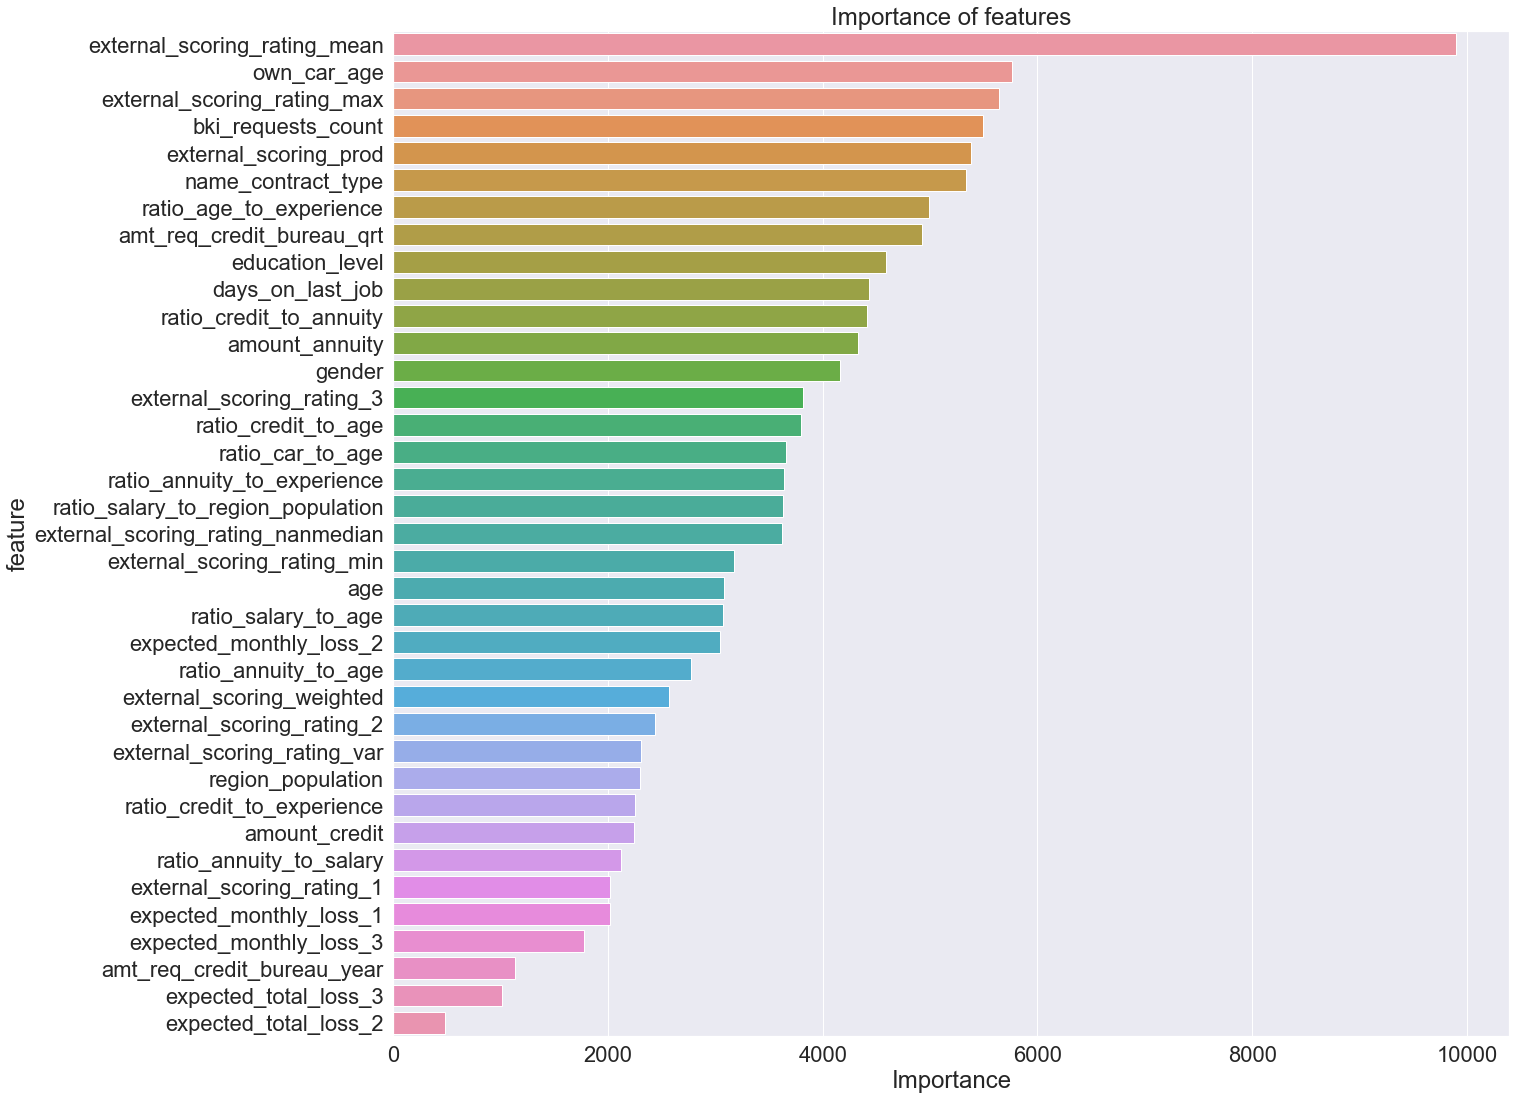

In [223]:
#cover
sns.set(font_scale = 2)
feature_important = estimators_xgb[0].get_score(importance_type='cover')
important_features_top2 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

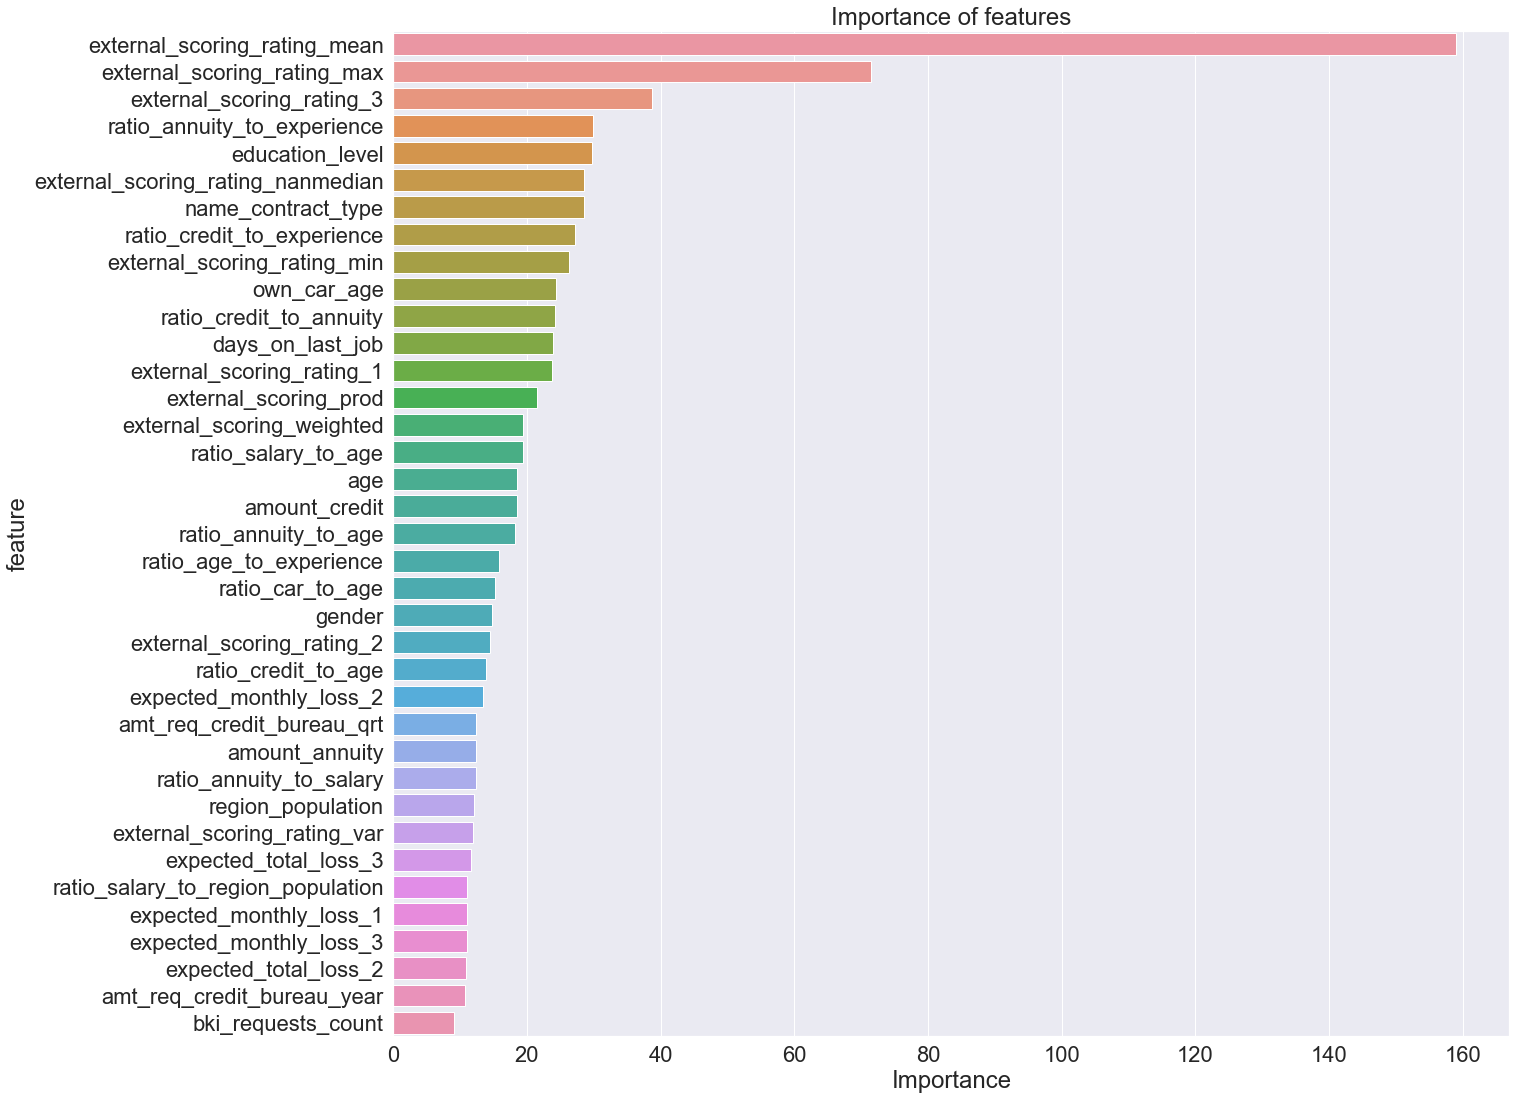

In [224]:
#gain
sns.set(font_scale = 2)
feature_important = estimators_xgb[0].get_score(importance_type='gain')
important_features_top3 = show_feature_importances(list(feature_important.keys()), list(feature_important.values()), get_top=30)
sns.set(font_scale = 1)

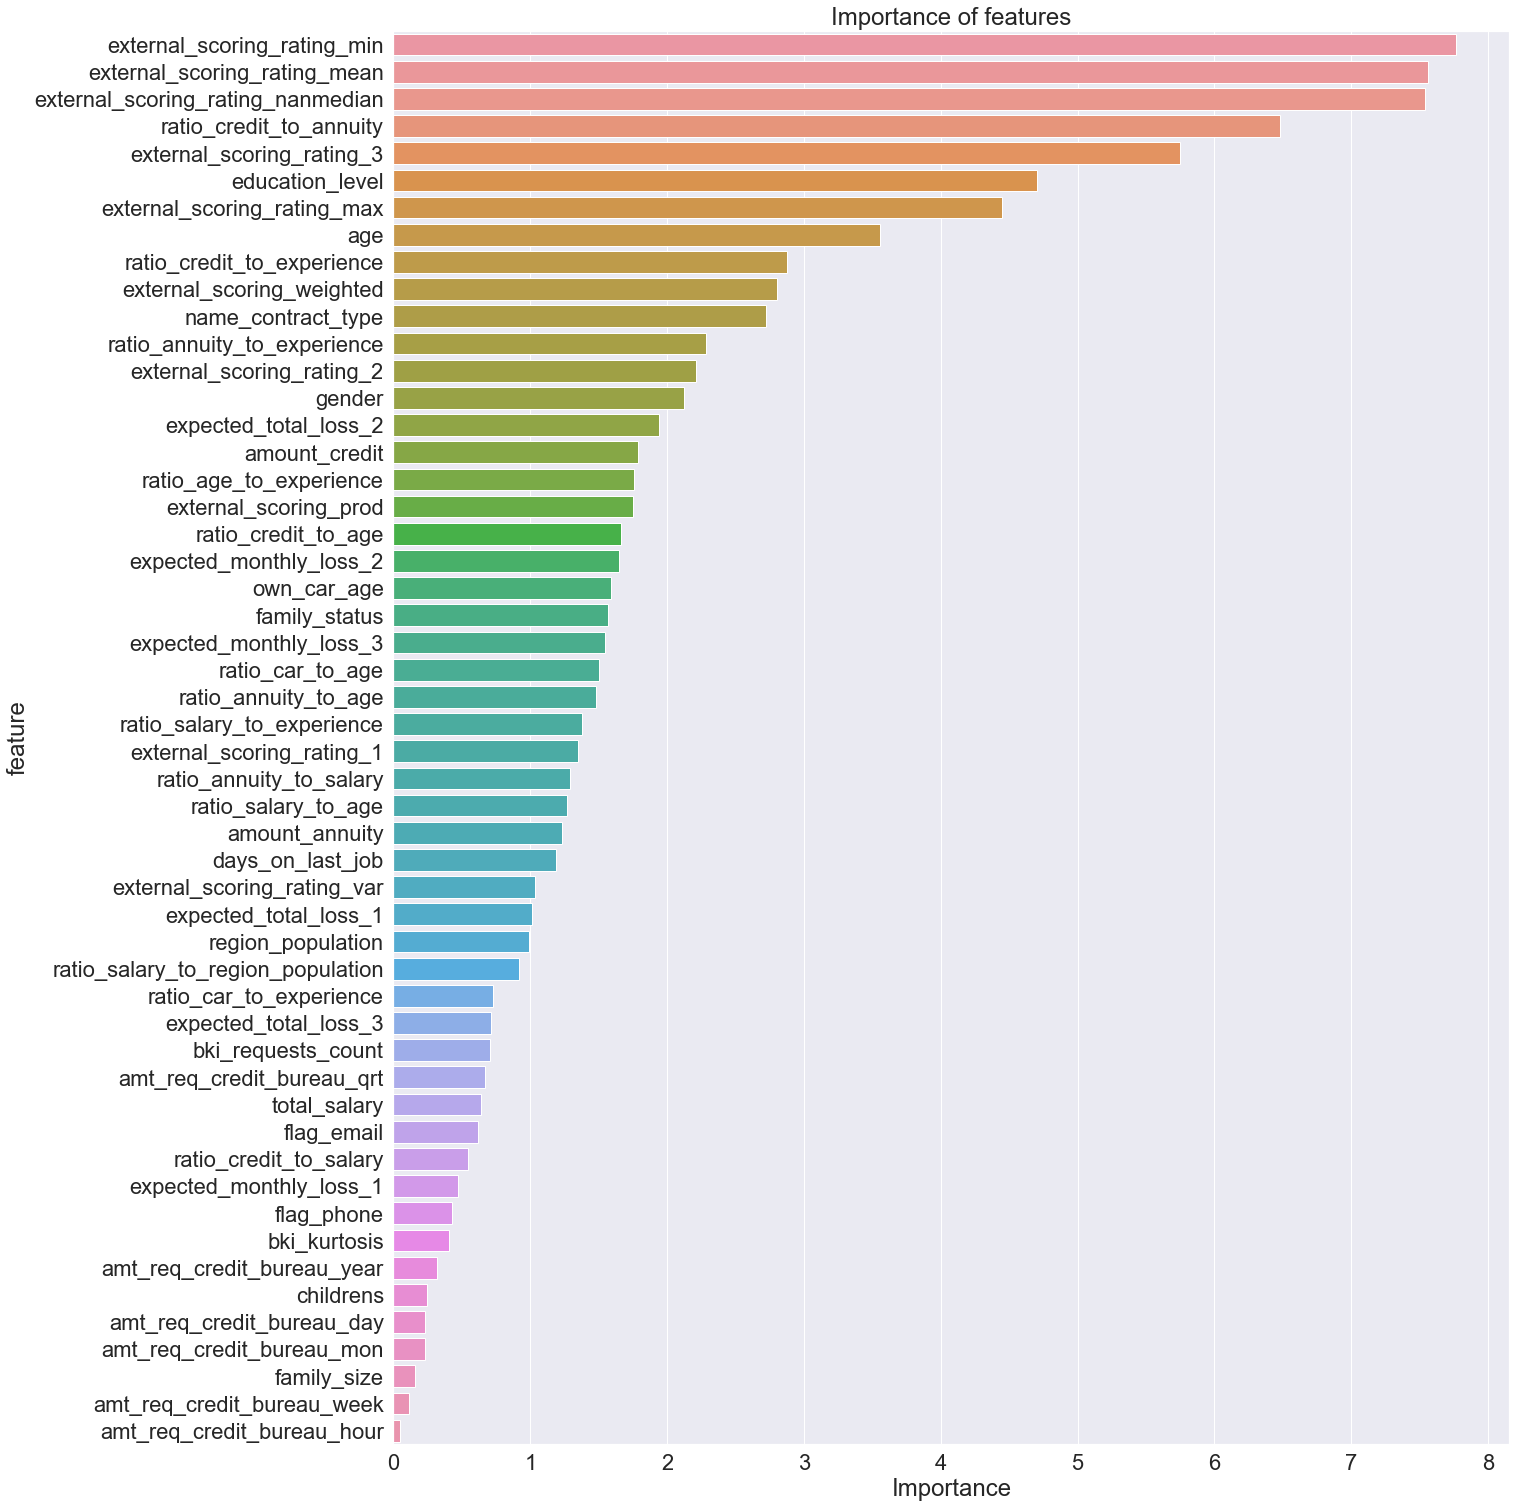

In [228]:
sns.set(font_scale = 2)
top_feat_catb = show_feature_importances(train.columns.tolist(), 
                                         estimators_catb[0].get_feature_importance().tolist(), 
                                         get_top=30)
sns.set(font_scale = 1)

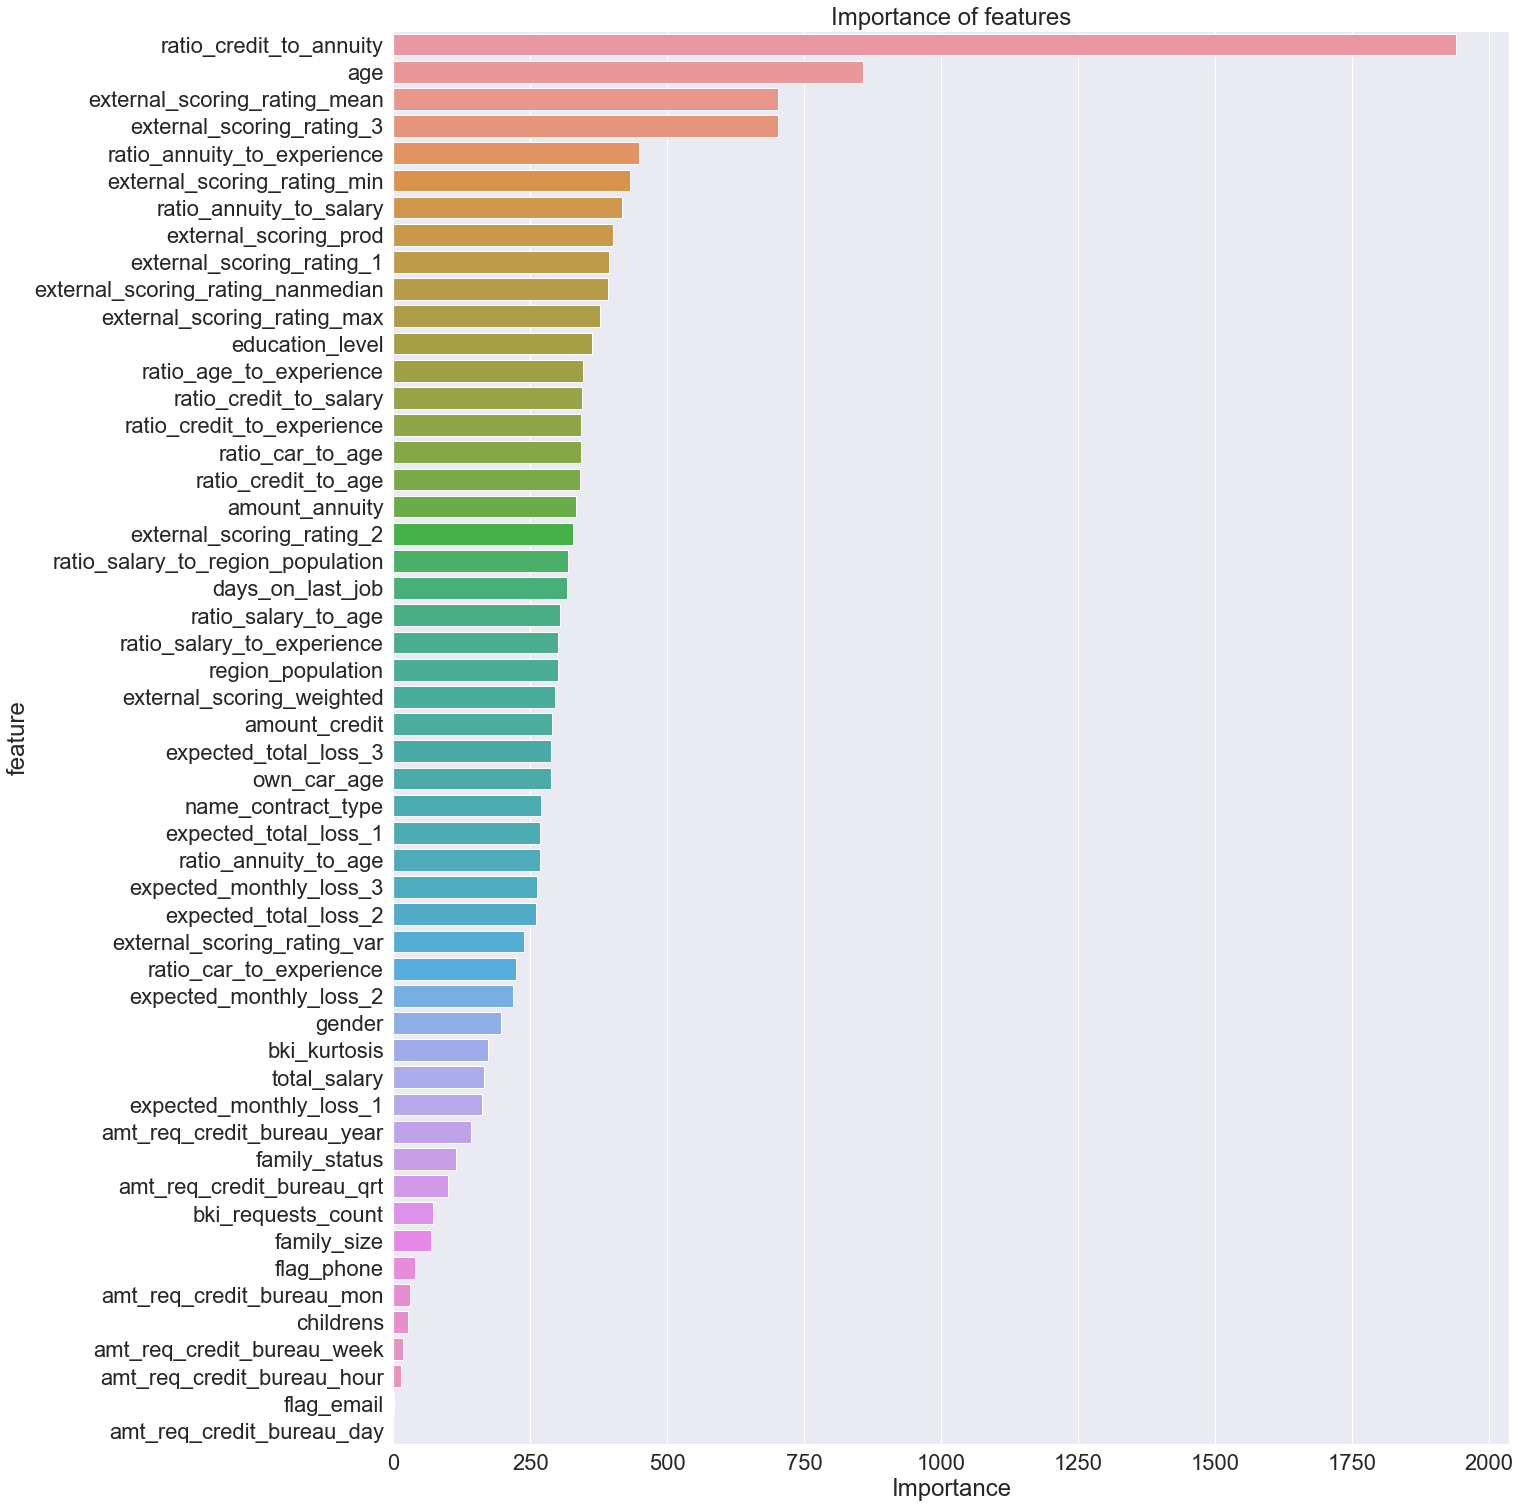

In [232]:
sns.set(font_scale = 2)
top_feat_lgb = show_feature_importances(train.columns.tolist(), estimators_lgb[0].feature_importance().tolist(), get_top=30)
sns.set(font_scale = 1)

In [233]:
#Самые важные признаки из всех моделей:
cols = set(important_features_top1 + important_features_top2 + important_features_top3 + top_feat_catb + top_feat_lgb)
len(cols)

40